## Load data

In [1]:
# import dependencies for loading data
from sklearn.datasets import load_files
from keras.utils import np_utils
from glob import glob
import numpy as np

Using TensorFlow backend.


In [2]:
# define function to load dataset
def load_dataset(path):
    data = load_files(path)
    x_files = np.array(data['filenames'])
    y_targets = np_utils.to_categorical(np.array(data['target']), 12)
    return x_files, y_targets

#load dataset
x_files, y_targets = load_dataset('data/train')
print('Total number of images: ', len(x_files)) #4750

#load list of categories
categories = [item[11:-1] for item in sorted(glob('data/train/*/'))]
print('List of categories: ', categories)


Total number of images:  4750
List of categories:  ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


## Data Exploration

### 1. Categorical distribution
To check if the dataset is balanced

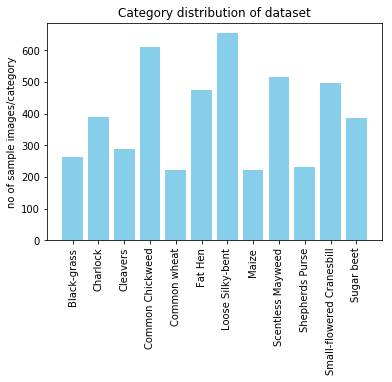

In [3]:
import matplotlib.pyplot as plt
'''
Function for displaying categorical data distribution to check if dataset is balanced
TODO: data augmentation if dataset is unbalanced
'''
category_count = np.sum(y_targets, axis = 0) # count of each class
def categorical_dist_graph(categories, count):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(categories)), count, color ='skyblue')
    ax.set_ylabel('no of sample images/category')
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation = 'vertical')
    ax.set_title('Category distribution of dataset')
    plt.show()

categorical_dist_graph(categories, category_count)

### 2. Display few sample images from each category

In [4]:
from collections import defaultdict
#creating dict with all categories as key, and their sample images as values
category_dict = defaultdict(list)
for category in categories:
    for i in range(len(x_files)):
        if category in x_files[i]:
            category_dict[category].append(x_files[i])

Black-grass


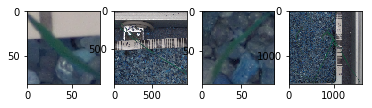

Charlock


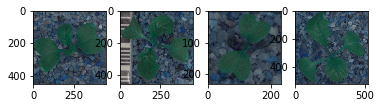

Cleavers


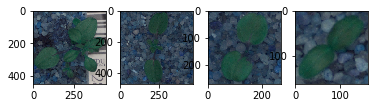

Common Chickweed


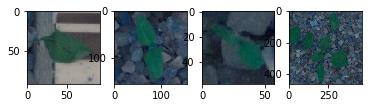

Common wheat


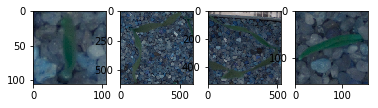

Fat Hen


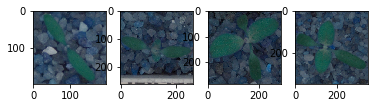

Loose Silky-bent


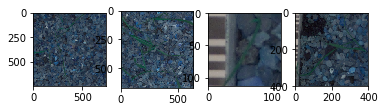

Maize


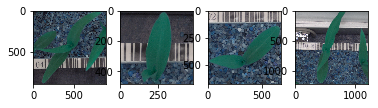

Scentless Mayweed


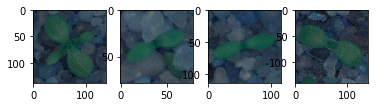

Shepherds Purse


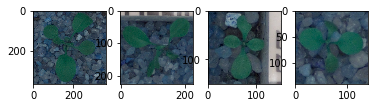

Small-flowered Cranesbill


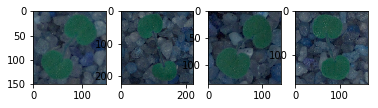

Sugar beet


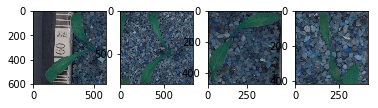

In [32]:
import random
import cv2
def show_sample(n = 3):
    '''
    displays given number of sample images from each of the categories
    '''
    for key in category_dict:
        print(key)
        fig = plt.figure()
        for i, j in enumerate(random.sample(range(len(category_dict[key])), n)):
            img = cv2.imread(category_dict[key][j])
            fig.add_subplot(1, n, i+1)
            plt.imshow(img)
        plt.show()

show_sample(4)

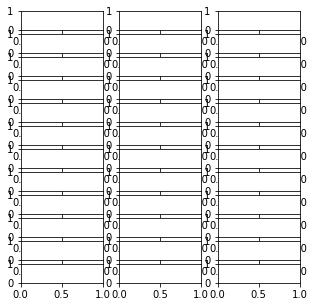

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.show()

## Train - validation split

In [57]:
data = load_files('data/train')

In [5]:
len(category_dict['Black-grass'])

263

In [98]:
print(category_dict)

defaultdict(<class 'list'>, {'Black-grass': ['data/train/Black-grass/92e5fcce4.png', 'data/train/Black-grass/c3b38d028.png'], 'Charlock': ['data/train/Charlock/143f07e0d.png', 'data/train/Charlock/ca1aaeb27.png', 'data/train/Charlock/95d959662.png', 'data/train/Charlock/1da9ac0ba.png', 'data/train/Charlock/1716acd53.png'], 'Cleavers': ['data/train/Cleavers/be41914d8.png', 'data/train/Cleavers/0a33283c7.png', 'data/train/Cleavers/3c2e76718.png'], 'Common Chickweed': ['data/train/Common Chickweed/aac309dc5.png', 'data/train/Common Chickweed/bfb59c16f.png', 'data/train/Common Chickweed/a9e03b3a1.png', 'data/train/Common Chickweed/fe1092cd5.png', 'data/train/Common Chickweed/c9d5d691e.png', 'data/train/Common Chickweed/b0b543038.png', 'data/train/Common Chickweed/70d2d710d.png', 'data/train/Common Chickweed/37b291dab.png', 'data/train/Common Chickweed/9ad3aa199.png']})


In [9]:
import random
for key in category_dict:
    print(key)
    for i in random.sample(range(len(category_dict[key])), 3):
        print(i, " ..", category_dict[key][i])

Black-grass
87  .. data/train/Black-grass/d622ca3d2.png
177  .. data/train/Black-grass/1276dffba.png
18  .. data/train/Black-grass/aa5bb06a1.png
Charlock
305  .. data/train/Charlock/b182916bb.png
7  .. data/train/Charlock/6b0964b5e.png
136  .. data/train/Charlock/81be6d02f.png
Cleavers
145  .. data/train/Cleavers/df341f2d4.png
114  .. data/train/Cleavers/0bcf29af7.png
140  .. data/train/Cleavers/794b914bf.png
Common Chickweed
246  .. data/train/Common Chickweed/06c42cf3f.png
213  .. data/train/Common Chickweed/b4e188202.png
389  .. data/train/Common Chickweed/9435b2c58.png
Common wheat
33  .. data/train/Common wheat/0df5ee8a2.png
111  .. data/train/Common wheat/835da3f0f.png
39  .. data/train/Common wheat/f08107bad.png
Fat Hen
171  .. data/train/Fat Hen/55fef4910.png
464  .. data/train/Fat Hen/8b3943e1e.png
94  .. data/train/Fat Hen/e6befd0af.png
Loose Silky-bent
1  .. data/train/Loose Silky-bent/d37099c79.png
592  .. data/train/Loose Silky-bent/a96276a20.png
506  .. data/train/Loose S